# Direct Model
## Setup

In [5]:
from src.data_utils import *
from src.train import * 

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

EDIBILITY = True
FINAL = True
HIGH_RES = False

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    
else:
    device = torch.device('cpu')

dtype = torch.float32
torch.backends.cudnn.benchmark = True

print('use cuda = ', torch.cuda.is_available())
print('using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
use cuda =  True
using device: cuda


## Load Dataset

In [6]:
if HIGH_RES:
    fname = "bolete.h5"
else:
    fname = "bolete_lowres.h5"

data = load_bolete_data(fname)

print()
for k in data.keys():
    print(k, np.shape(data[k]))

ItemsViewHDF5(<HDF5 file "bolete_lowres.h5" (mode r)>)

bolete-characteristics (38, 1868)
bolete-edibility (5, 1868)
bolete-images (3, 256, 256, 1868)
bolete-labels (1868,)


## Split into train and test

In [7]:
if EDIBILITY:
    X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, "bolete-edibility")
    M = Y_train.shape[1]
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)
    
else:
    X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, "bolete-labels")
    M = np.size(np.unique(Y_train))

N, H, W, C = X_train.shape

Y_train = Y_train.astype(np.long)
Y_test = Y_test.astype(np.long)

print(X_train.shape)
print(Y_train.shape)
print(y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(y_test.shape)

(1307, 3, 256, 256)
(1307,)
(1307,)
(561, 3, 256, 256)
(561,)
(561,)


## Define models

In [8]:
def simple_model():
    # copy final model from ass igment 2
    def flatten(x):
        """Flattens to [N, -1] where -1 is whatever it needs to be"""
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  
        # "flatten" the C * H * W values into a single vector per image
    class Flatten(nn.Module):
        def forward(self, x):
            return flatten(x)

    channel_1 = 32
    channel_2 = 24
    channel_3 = 16
    hidden_dim = 150
    learning_rate = 3e-3 # 1e-2

    model = nn.Sequential(
        nn.Conv2d(C, channel_1, kernel_size=5, padding=2),
        # nn.GroupNorm(4,channel_1),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_3),
        nn.BatchNorm2d(channel_3),
        nn.ReLU(),
        nn.Dropout(0.1),
        Flatten(),
        nn.Linear(channel_3 * H * W, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, M)
    )
    
    return model

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

def modified_alexnet():
    model = models.alexnet(pretrained=True)
    model = freeze(model)

    # model.classifier[0] = ???
    model.classifier[6] = nn.Linear(in_features=4096, out_features=M, bias=True)
    # print(model)
    return model

def modified_googlenet():
    model = models.googlenet(pretrained=True)
    model = freeze(model)

    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(in_features=fc_in_feats, out_features=M, bias=True)
    # print(model)
    return model

def modified_resnext():
    model = models.resnext101_32x8d(pretrained=True)
    model = freeze(model)
    
    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(fc_in_feats, M)
    return model

## Define the loss function

In [9]:
loss_fn = nn.CrossEntropyLoss()

def pred_fn(scores):
    m = nn.Softmax(dim=1)
    return torch.argmax(m(scores), dim=1)

## Cross Validate on training data

In [10]:
# model = simple_model()
# model = modified_alexnet()
model = modified_googlenet()
# model = modified_resnext()


if EDIBILITY:
    optimizer = optim.RMSprop(
        model.parameters(),
        lr=5e-4,
        momentum=0.4,
        alpha=0.99
        )
else:
    optimizer = optim.RMSprop(
        model.parameters(),
        lr=1e-3,
        momentum=0.4,
        alpha=0.99
        )

transform = T.Compose([T.ToTensor()])
if EDIBILITY:
    batch_size = 128
    num_epochs = 60
else:
    batch_size = 8
    num_epochs = 40

num_folds = 1

torch.manual_seed(0)
history = cross_val(
    X_train=X_train,
    Y_train=Y_train,
    y_train=y_train,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    pred_fn=pred_fn,
    batch_size=batch_size,
    num_epochs=num_epochs,
    num_classes=1,
    show_every=1,
    folds=num_folds,
    test_size=0.2,
    device=device,
    dtype=dtype,
    transform=None,
)

CV model on:  cuda
CV Fold:  1
Training model on:  cuda
Iter: 0
train Loss: 1.3684 Acc: 0.4670
Iter: 1
val Loss: 1.2733 Acc: 0.3893
Iter: 2
train Loss: 1.2221 Acc: 0.5043
Iter: 3
val Loss: 1.2281 Acc: 0.5153
Iter: 4
train Loss: 1.1697 Acc: 0.5378
Iter: 5
val Loss: 1.1955 Acc: 0.5191
Iter: 6
train Loss: 1.1432 Acc: 0.5569
Iter: 7
val Loss: 1.1815 Acc: 0.5191
Iter: 8
train Loss: 1.1204 Acc: 0.5579
Iter: 9
val Loss: 1.1725 Acc: 0.5191
Iter: 10
train Loss: 1.1007 Acc: 0.5656
Iter: 11
val Loss: 1.1657 Acc: 0.5191
Iter: 12
train Loss: 1.0870 Acc: 0.5684
Iter: 13
val Loss: 1.1595 Acc: 0.5191
Iter: 14
train Loss: 1.0794 Acc: 0.5694
Iter: 15
val Loss: 1.1520 Acc: 0.5229
Iter: 16
train Loss: 1.0656 Acc: 0.5627
Iter: 17
val Loss: 1.1503 Acc: 0.5267
Iter: 18
train Loss: 1.0511 Acc: 0.5962
Iter: 19
val Loss: 1.1496 Acc: 0.5267
Iter: 20
train Loss: 1.0450 Acc: 0.5933
Iter: 21
val Loss: 1.1426 Acc: 0.5267
Iter: 22
train Loss: 1.0315 Acc: 0.5933
Iter: 23
val Loss: 1.1424 Acc: 0.5305
Iter: 24
train Los

## Plot Training History

{'train_loss': [[1.3684430253562745, 1.2221091643474888, 1.1697338813799991, 1.1431975444538172, 1.1204206017786236, 1.1007363720373673, 1.0869953451544474, 1.0794385099525086, 1.0655542914947254, 1.051063315720079, 1.0450269766971825, 1.0315009887138622, 1.0302213006042407, 1.0216077453211734, 1.0136301680044695, 1.0035977193613372, 0.9907493275888799, 0.9841343607058365, 0.9894114171489004, 0.9815508427802455, 0.9737539382642536, 0.9585225377356607, 0.9445371820595846, 0.9347546675844055, 0.9412774172125821, 0.9406256623815692, 0.9334532187030646, 0.9292968056133489, 0.9231796329101307, 0.9122397635542034, 0.9148875073382728, 0.9000310653704776, 0.9006065541762485, 0.8849809516274758, 0.9036565407896726, 0.8811646030850387, 0.8926727175712585, 0.8815614880272076, 0.8715737298630071, 0.866359897492605, 0.886914830173602, 0.8626109246146736, 0.8754875703576649, 0.8574537005435907, 0.8600841209078519, 0.8575207986329731, 0.8567726699644299, 0.849387117949399, 0.8492074060668215, 0.85347

True

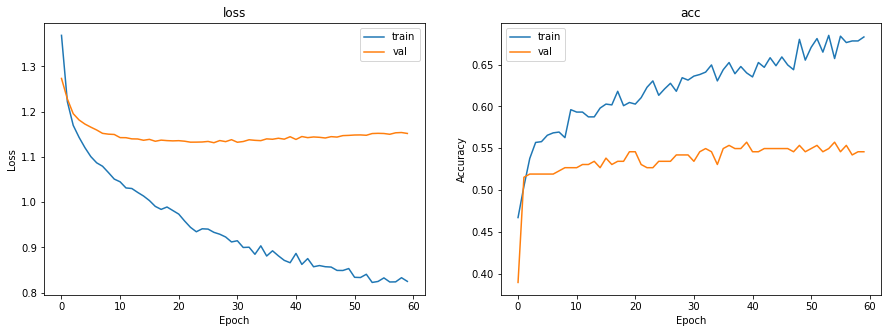

In [11]:
fig, axes = plt.subplots(1, 2, figsize=[15,5], sharex=False, sharey=False)
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")

plotnum = 0

phase = ["train", "val"]
for s in ["loss", "acc"]:
    for a in phase:
        axes[plotnum].set_title(s)
        axes[plotnum].set_xlabel("Epoch")
        axes[plotnum].plot(np.mean(history[a+'_'+s], axis=0))
        axes[plotnum].legend(phase)
    plotnum += 1
print(history, "direct_"+fname, EDIBILITY)
ed = "ed_" if EDIBILITY else ""
save_history_data(history, "direct_"+ed+fname, edibility=EDIBILITY, num_folds=num_folds)

## Train on all the data

In [12]:
if FINAL:
    model = modified_googlenet()
    if EDIBILITY:
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=5e-4,
            momentum=0.4,
            alpha=0.99
            )

        if fname == "bolete.h5":
            num_epochs = num_epochs
        else:
            num_epochs = 20
    else:
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=1e-3,
            momentum=0.4,
            alpha=0.99
            )
        if fname == "bolete.h5":
            num_epochs = 15
        else:
            num_epochs = 7
    
    dataloader_tr = get_loader(X_train, Y_train, batch_size)
    dataloader_val = get_loader(X_test, Y_test, batch_size)
    dataloaders = {"train":dataloader_tr, "val":dataloader_val}
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(
        model,
        optimizer,
        dataloaders,
        loss_fn,
        pred_fn,
        num_epochs,
        num_classes=1,
        show_every=1,
        device=device,
        dtype=dtype,
    )

Training model on:  cuda
Iter: 0
train Loss: 1.3645 Acc: 0.4560
Iter: 1
val Loss: 1.3089 Acc: 0.5419
Iter: 2
train Loss: 1.1941 Acc: 0.5455
Iter: 3
val Loss: 1.2608 Acc: 0.5419
Iter: 4
train Loss: 1.1582 Acc: 0.5463
Iter: 5
val Loss: 1.2350 Acc: 0.5419
Iter: 6
train Loss: 1.1284 Acc: 0.5578
Iter: 7
val Loss: 1.2160 Acc: 0.5419
Iter: 8
train Loss: 1.1096 Acc: 0.5570
Iter: 9
val Loss: 1.2113 Acc: 0.5419
Iter: 10
train Loss: 1.0931 Acc: 0.5647
Iter: 11
val Loss: 1.2061 Acc: 0.5437
Iter: 12
train Loss: 1.0716 Acc: 0.5708
Iter: 13
val Loss: 1.1953 Acc: 0.5437
Iter: 14
train Loss: 1.0685 Acc: 0.5784
Iter: 15
val Loss: 1.1909 Acc: 0.5437
Iter: 16
train Loss: 1.0513 Acc: 0.5777
Iter: 17
val Loss: 1.1852 Acc: 0.5383
Iter: 18
train Loss: 1.0365 Acc: 0.5761
Iter: 19
val Loss: 1.1823 Acc: 0.5419
Iter: 20
train Loss: 1.0303 Acc: 0.5899
Iter: 21
val Loss: 1.1832 Acc: 0.5419
Iter: 22
train Loss: 1.0247 Acc: 0.5914
Iter: 23
val Loss: 1.1741 Acc: 0.5401
Iter: 24
train Loss: 1.0087 Acc: 0.5930
Iter: 25


In [13]:
if FINAL:
    final_history = {
        "train_acc": [train_acc_history],
        "train_loss": [train_loss_history],
        "val_acc": [val_acc_history],
        "val_loss": [val_loss_history],
    }
    ed = "ed_" if EDIBILITY else ""
    save_history_data(final_history, "direct_"+ed+"final_"+fname, edibility=EDIBILITY, num_folds=1)

history_data_ed/direct_ed_final_bolete_lowres.h5_history.csv


## Evaluate 

In [14]:
if FINAL:
    X, Y, y = X_test, Y_test, y_test
else:
    X, Y, y = get_val(X_train, Y_train, y_train)

scores, y_pred, y_true, y_labels = evaluate(
    X,  # images
    Y,  # output
    y,  # labels
    model,
    out_dim=M,
    pred_fn=pred_fn,
    device=device,
    transform=None,
)
if EDIBILITY:
    save_raw_eval_data(scores, y_pred, y_true, y_labels, "direct_ed_"+fname)
else:
    save_raw_eval_data(scores, y_pred, y_true, y_labels, "direct_"+fname)

Evaluating model on:  cuda


### Check status of GPU Memory for Debugging Purposes

In [11]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([])
<class 'torc